#### Import Modules

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, roc_curve
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Data Cleaning and Preprocessing

Handling missing values and explore the data.

In [49]:
def file():
    df = pd.read_csv("flag.data")   
    df1 = pd.read_csv("flag columns name.txt")
    df.columns = df1.columns
    #Combine columns with data into a new csv file
    #df.to_csv("flag.csv")

def handleMis():    #Handling missing values:
    #Since only blank fields and NA are recognised as missing values, include all possible missing values  
    misVal = ["Na","n/a", "na", "-", "?"]
    df = pd.read_csv("flag.csv", na_values = misVal, sep = ",")
    df1 = df.copy() #create copy for preprocessing
    print("\nNumber of instances: {}".format(df.shape[0]))    #find number of rows and columns
    print("Number of columns: {}\n".format(df.shape[1]))
    df1.replace(misVal, np.NaN, inplace=True)     #replace all missing values as NaN 
    df1.columns = df1.columns.str.strip()
    print("{}\n".format(df1.head()))     
    print("{}\n".format(df1.info()))             #check columns with non-numerical values
    print("{}\n".format(df1.isna().sum()))       #check if there is any null values 
    #There is no missing value in this dataset. 
    df1.drop(["Unnamed: 0"], axis=1, inplace=True)  #Drop the column Unnamed
    
    return df1

file()
df1 = handleMis()


Number of instances: 193
Number of columns: 31

   Unnamed: 0            name  landmass  zone  area  population  language  \
0           0         Albania         3     1    29           3         6   
1           1         Algeria         4     1  2388          20         8   
2           2  American-Samoa         6     3     0           0         1   
3           3         Andorra         3     1     0           0         6   
4           4          Angola         4     2  1247           7        10   

   religion  bars  stripes  ...  saltires  quarters  sunstars  crescent  \
0         6     0        0  ...         0         0         1         0   
1         2     2        0  ...         0         0         1         1   
2         1     0        0  ...         0         0         0         0   
3         0     3        0  ...         0         0         0         0   
4         5     0        2  ...         0         0         1         0   

   triangle  icon  animate  text topl

Drop duplicated columns.

In [50]:
def dup():
    print("{}\n".format(df1[df1.duplicated()]))     #Check for duplicated rows:
    print("Number of Duplicated rows:{}\n".format(df1.duplicated().sum()))
    #There are no duplicated rows, No need df1.drop_duplicates().
    
dup()

Empty DataFrame
Columns: [name, landmass, zone, area, population, language, religion, bars, stripes, colours, red, green, blue, gold, white, black, orange, mainhue, circles, crosses, saltires, quarters, sunstars, crescent, triangle, icon, animate, text, topleft, botright]
Index: []

[0 rows x 30 columns]

Number of Duplicated rows:0



We can see that there are very little data of 4=German, 9=Japanese/Turkish/Finnish/Magyar, 7=Others, 5=Slavic. This might result in issue for the model when we split the data as the test data might not or include very little of these classes.

Text(0.5, 1.0, 'Frequency of the target label')

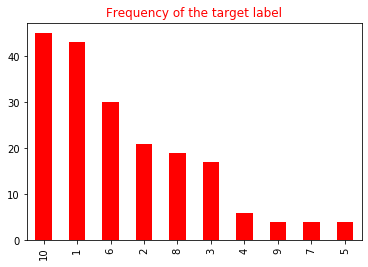

In [51]:
df1["language"].value_counts().plot.bar(color = "r")  #frequency of target label
plt.title("Frequency of the target label", color = "r") 

In [52]:
df1.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,...,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.564767,2.217617,700.316062,23.305699,5.316062,2.191710,0.455959,1.544041,3.455959,0.787565,...,0.170984,0.150259,0.093264,0.150259,1.388601,0.056995,0.139896,0.248705,0.202073,0.082902
std,1.553625,1.308745,2176.570790,92.171685,3.489359,2.066482,1.040522,2.331706,1.298789,0.410095,...,0.464116,0.386238,0.291559,0.436860,4.407531,0.232436,0.347782,0.433386,0.402590,0.276450
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,463.000000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,...,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Label Encode all categorical columns for Decision Tree Classifier. Even though all the categorical 
columns are nominal, one-hot encode will cause inefficiency to decision tree classifier. 

In [53]:
def encode():
    df2 = df1.copy()  #create another df copy
    lbEnc = LabelEncoder()  #Use Label encoding for decision tree
    catCols =df2.columns[df2.dtypes==np.object]  #Object columns
    #Check number of categories for object columns
    leCols = (df2[catCols].apply(lambda x: x.nunique()).sort_values(ascending=False))
    for col in catCols:     #Label Encode all object columns
        df2[col] = lbEnc.fit_transform(df1[col]).astype(np.int64)
    print("Number of categories in the object columns:\n{}\n".format(leCols))
    print("New number of rows and columns{}\n".format(df2.shape))
    print("{}\n".format(df2.head()))  #check the new dataframe
    
    return df2

df2 = encode()

Number of categories in the object columns:
name        193
botright      8
mainhue       8
topleft       7
dtype: int64

New number of rows and columns(193, 30)

   name  landmass  zone  area  population  language  religion  bars  stripes  \
0     0         3     1    29           3         6         6     0        0   
1     1         4     1  2388          20         8         2     2        0   
2     2         6     3     0           0         1         1     0        0   
3     3         3     1     0           0         6         0     3        0   
4     4         4     2  1247           7        10         5     0        2   

   colours  ...  saltires  quarters  sunstars  crescent  triangle  icon  \
0        3  ...         0         0         1         0         0     0   
1        3  ...         0         0         1         1         0     0   
2        5  ...         0         0         0         0         1     1   
3        3  ...         0         0         0         0 

For the Logistic Regression and Naive Bayes Classifier, we will label encode the name categorical and
one-hot encode the remaining columns. 

In [54]:
def catEncode(df1):
    
    labEnc = LabelEncoder()
    #too many additional columns if we do one-hot encode, even though is nominal     
    df1["name"] = labEnc.fit_transform(df2.name).astype(np.int64)  #label encode country names
    cCols = df1.columns[df1.dtypes==np.object]  #Object columns
    #Check number of categories for object columns
    leCols = (df1[cCols].apply(lambda x: x.nunique()).sort_values())
    #for col in catCols:     #Label Encode all object columns
        #df1[col] = labEnc.fit_transform(df1[col]).astype(np.int64)
    df1 = pd.get_dummies(df1, drop_first=True).astype(np.int64) #one-hot encode object columns
    print("New number of rows and columns{}\n".format(df1.shape))
    print("{}\n".format(df1.head()))    #check the new dataframe
    
    return df1

df1 = catEncode(df1)

New number of rows and columns(193, 47)

   name  landmass  zone  area  population  language  religion  bars  stripes  \
0     0         3     1    29           3         6         6     0        0   
1     1         4     1  2388          20         8         2     2        0   
2     2         6     3     0           0         1         1     0        0   
3     3         3     1     0           0         6         0     3        0   
4     4         4     2  1247           7        10         5     0        2   

   colours  ...  topleft_orange  topleft_red  topleft_white  botright_blue  \
0        3  ...               0            1              0              0   
1        3  ...               0            0              0              0   
2        5  ...               0            0              0              0   
3        3  ...               0            0              0              0   
4        3  ...               0            1              0              0   

   botrig

### Decision Tree Classifier

Scaling is not required for decision tree classifier. Proceed to train, test and split the dataset. Create the instance and train the model.

In [56]:
def ttSpt(df2):
    fcols = [x for x in df2.columns if x not in "language"]  #select all feature columns
    #Alternatively, y_col, fcols = "language", [x for x in df1.columns if x != y_col]
    X, y = df2[fcols], df2["language"]  #X as feature columns, y as target columns
    #Test, train and split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)
    #create instance of decision tree model and train Decision Tree Classifer
    dtc = DecisionTreeClassifier(random_state=123).fit(X_train,y_train)  
    y_tr_pred = dtc.predict(X_train)  #Predict the response for test dataset
    y_te_pred = dtc.predict(X_test)
    
    return dtc, fcols, X_train, X_test, y_train, y_test, y_tr_pred, y_te_pred

dtc, fcols, X_train, X_test, y_train, y_test, y_tr_pred, y_te_pred  = ttSpt(df2)

Evaluate the performance with the classification metrics.

In [57]:
def score(y_tr, y_pr, colname):
    score = pd.Series({"accuracy":accuracy_score(y_tr, y_pr),  #Evaluate with classification metrics
                        "precision": precision_score(y_tr, y_pr, average="weighted"),
                        "recall": recall_score(y_tr, y_pr, average="weighted"),
                        "f1": f1_score(y_tr, y_pr, average="weighted")}, name=colname)

    return score


metric = pd.concat([score(y_train, y_tr_pred, "train"), score(y_test, y_te_pred, "test")], axis=1)
metric

,train,test
accuracy,1.0,0.637931
precision,1.0,0.628038
recall,1.0,0.637931
f1,1.0,0.629327


In [58]:
confusion_matrix(y_test, y_te_pred)

array([[ 8,  0,  1,  0,  0,  2,  0,  0,  0,  2],
       [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 2,  0,  0,  1,  1,  4,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  1,  0,  0,  0, 11]], dtype=int64)

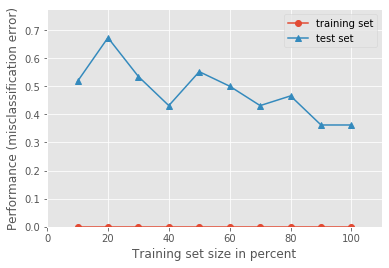

In [59]:
plot_learning_curves(X_train, y_train, X_test, y_test, dtc, print_model=False, style="ggplot")
plt.show()

The model overfits and have a high variance problem. Let use ensemble methods such as bagging to reduce the chance of overfitting.

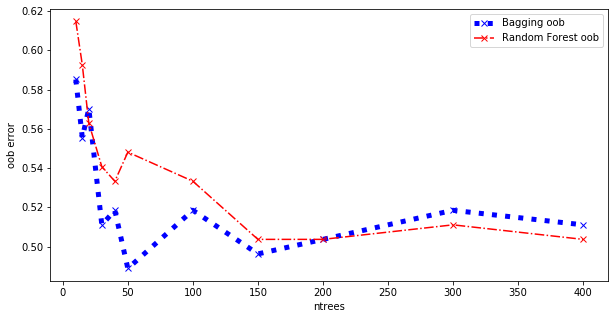

In [60]:
def ensem(dtc, X_train, y_train):
    #Use bagging classifier 
    bc = BaggingClassifier(dtc, oob_score=True, random_state=123)
    rfc = RandomForestClassifier(dtc, oob_score=True, warm_start=False, random_state=123)
    rfcoob, bcoob = [], [] #create a list to store
    # Iterate through the number of trees to find best n_estimator
    for ntrees in [10, 15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
        bc.set_params(n_estimators=ntrees), rfc.set_params(n_estimators=ntrees)  #set number of trees
        bc.fit(X_train, y_train), rfc.fit(X_train, y_train)    #Fit the model
        oob_err = 1 - bc.oob_score_ 
        oob = 1 - rfc.oob_score_ #Get the oob error of both classifer
        bcoob.append(pd.Series({"n_trees": ntrees, "Bagging oob": oob_err}))
        rfcoob.append(pd.Series({"n_trees": ntrees, "Random Forest oob": oob}))
        ooberr = pd.concat(bcoob, axis=1).T.set_index('n_trees')
        ooberror = pd.concat(rfcoob, axis=1).T.set_index("n_trees")
    
    return rfc, bc, ooberr, ooberror

def plot():
    fig, ax = plt.subplots(figsize=(10,5))   #plot visualisation chart 
    ax.plot(ooberr, c="b",  marker='x', label="Bagging oob", linewidth=5, linestyle="dotted")
    ax.plot(ooberror, c="r", marker='x',label="Random Forest oob", linestyle="dashdot")
    ax.set(xlabel="ntrees", ylabel="oob error")
    plt.legend(loc="upper right")

rfc, bc, ooberr, ooberror = ensem(dtc, X_train, y_train)
plot()

From the plot, the Bagging classifier performs generally better than the Random Tree Classifier when n_estimator < 200, and stabilises around 150 trees. We will set the n_estimators as 150 using bagging classifier.

In [61]:
def ensempar(bc, X_test, X_train):
    bc = bc.set_params(n_estimators=150)  #set the parameter
    ytestpred = bc.predict(X_test)    #Predict the response for test dataset
    ytrainpred = bc.predict(X_train)
    
    return bc, ytestpred, ytrainpred 

bc, ytestpred, ytrainpred = ensempar(bc, X_test, X_train)

In [62]:
def ensemScore(ytr, ypr, coname): 
    #Evaluate with classification metrics
    ascore = pd.Series({"accuracy": accuracy_score(ytr, ypr),  
                        "precision": precision_score(ytr, ypr,  average='weighted'),
                        "recall": recall_score(ytr, ypr,  average='weighted'),
                        "f1": f1_score(ytr, ypr,  average='weighted')}, name=coname)

    return ascore 

bagmetrics = pd.concat([ensemScore(y_train, ytrainpred, "train"), 
                       ensemScore(y_test, ytestpred, "test")], axis=1)
bagmetrics

,train,test
accuracy,1.0,0.741379
precision,1.0,0.687453
recall,1.0,0.741379
f1,1.0,0.704513


In [63]:
print(classification_report(y_test, ytestpred))

              precision    recall  f1-score   support

           1       0.73      0.85      0.79        13
           2       0.86      1.00      0.92         6
           3       0.50      0.20      0.29         5
           4       0.33      0.50      0.40         2
           5       0.00      0.00      0.00         1
           6       0.50      0.44      0.47         9
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         6
           9       0.00      0.00      0.00         1
          10       0.82      1.00      0.90        14

    accuracy                           0.74        58
   macro avg       0.47      0.50      0.48        58
weighted avg       0.69      0.74      0.70        58



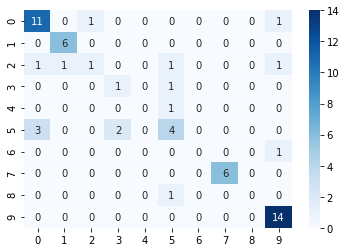

In [64]:
conf = confusion_matrix(y_test, ytestpred)  #plot confusion matrix
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")

Accuracy improved slightly after using bagging classifier. However, there are 0 samples of 
the true response in some classes. Need more data for language which is not noisy.

### Logistic Regression Classifier

Scale the data. Train, test and split the dataset. Create the instance and train the model.

In [65]:
def trteSp(df1):
    fcols = [x for x in df1.columns if x not in "language"]     #select all feature columns
    X, y = df1[fcols], df1["language"]      #X as feature columns, y as target columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)
    scale = StandardScaler()    #Scale the data
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    #create instance of Logistic Regression Classifier and train 
    lr = LogisticRegression(random_state=123).fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)     #Predict the response for test dataset
    y_test_pred = lr.predict(X_test)
    print("accuracy-test: {:.6f}".format(accuracy_score(y_test, y_test_pred)))
     
    return lr, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

lr, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = trteSp(df1)

accuracy-test: 0.500000


Fine-tune the model parameter using RandomizedSearchCV.

In [66]:
def rsSea(lr, X_train, X_test, y_train, y_test):
    #input parameters for fine tuning
    c_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
    pen = ["l2","l1", "elasticnet","none"] 
    solver = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]   
    param_dist = {"C":c_range, "penalty": pen, "solver": solver}   
    lr_cv = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, scoring="accuracy", 
                               cv=3, random_state=1).fit(X_train,y_train)  #using acc scoring 
    lr_cv_pr = lr_cv.predict(X_test)     
    print("The best parameters {} with an accuracy score of {:.4f}.".format(lr_cv.best_params_ , 
           accuracy_score(y_test,lr_cv_pr)))   #get parameter of highest acc for LR classifier 
    
rsSea(lr, X_train, X_test, y_train, y_test)

The best parameters {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01} with an accuracy score of 0.5517.


In [67]:
def tune():  #fine tune parameter of lr
    lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear",random_state=123).fit(X_train, y_train)    
    y_train_pred = lr.predict(X_train)     #Predict the response for test dataset
    y_test_pred = lr.predict(X_test)

    return lr, y_train_pred, y_test_pred

lr, y_train_pred, y_test_pred = tune()

Evaluate the mean squared error and classification metrics of the model.

In [68]:
def scor(ytrain, ypred, lab):
    #Evaluate with classification metrics
    bscore = pd.Series({"accuracy": accuracy_score(ytrain, ypred),  
                        "precision": precision_score(ytrain, ypred,  average='weighted'),
                        "recall": recall_score(ytrain, ypred,  average='weighted'),
                        "f1": f1_score(ytrain, ypred,  average='weighted'),
                        "mean squared error": mean_squared_error(ytrain, ypred)}, name=lab)
    
    return bscore
   
lrmetrics = pd.concat([scor(y_train, y_train_pred, "train"), scor(y_test, y_test_pred, "test")], axis=1)
lrmetrics

,train,test
accuracy,0.637037,0.551724
precision,0.648281,0.484779
recall,0.637037,0.551724
f1,0.611250,0.506631
mean squared error,7.933333,9.775862


In [69]:
confusion_matrix(y_test, y_test_pred)

array([[10,  1,  0,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  5,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  2,  2,  0,  0,  1,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  3,  0,  2],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  1,  0, 11]], dtype=int64)

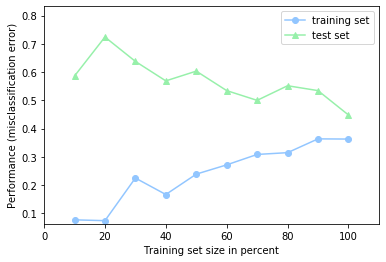

In [70]:
plot_learning_curves(X_train, y_train, X_test, y_test, lr, print_model=False, style="seaborn-pastel")
plt.show()

The model underfits and have high bias. Let's use ensemble methods such as boosting to boost the aggregate complexity.

In [71]:
def boost(lr, X_train, X_test, y_train, y_test):
    #Using Gradient Boost Classifier
    GBC = GradientBoostingClassifier(learning_rate=0.1, random_state=123).fit(X_train, y_train)
    error = [1-accuracy_score(y_test, y_pred) for y_pred in GBC.staged_predict(X_test)]
    n_esti = np.argmin(error) #get n_estimator with minimum error
    GBC = GradientBoostingClassifier(n_estimators=n_esti, learning_rate=0.1, random_state=123).fit(X_train, y_train)
    y_tespred = GBC.predict(X_test)
    y_trapred = GBC.predict(X_train)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
          .format(accuracy_score(y_train, y_trapred), accuracy_score(y_test, y_tespred)))
    print("mean_squared_error-train: {:.6f} \nmean_squared_error-test: {:.6f}"
          .format(mean_squared_error(y_train, y_trapred), mean_squared_error(y_test, y_tespred)))
    
    return GBC

GBC = boost(lr, X_train, X_test, y_train, y_test)

accuracy-train: 0.977778 
accuracy-test: 0.706897
mean_squared_error-train: 0.281481 
mean_squared_error-test: 6.500000


Stack the model of both Logistic Regression and Gradient Boost using Voting Classifier. 

In [72]:
def vote():
    estimators = [("lr", lr), ("GBC", GBC)]   #Combine both models
    VC = VotingClassifier(estimators, voting="soft", flatten_transform="True")
    VC = VC.fit(X_train, y_train)  
    y_testpred = VC.predict(X_test)
    y_trainpred = VC.predict(X_train)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
          .format(accuracy_score(y_train, y_trainpred), accuracy_score(y_test, y_testpred)))
    print("mean_squared_error-train: {:.6f} \nmean_squared_error-test: {:.6f}"
          .format(mean_squared_error(y_train, y_trainpred), mean_squared_error(y_test, y_testpred)))
    
    return VC, y_testpred, y_trainpred

VC, y_testpred, y_trainpred = vote()

accuracy-train: 0.977778 
accuracy-test: 0.724138
mean_squared_error-train: 0.281481 
mean_squared_error-test: 5.103448


In [73]:
print(classification_report(y_train, y_trainpred))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        15
           3       1.00      0.92      0.96        12
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       0.95      0.95      0.95        21
           7       1.00      1.00      1.00         3
           8       0.93      1.00      0.96        13
           9       1.00      1.00      1.00         3
          10       1.00      0.97      0.98        31

    accuracy                           0.98       135
   macro avg       0.98      0.98      0.98       135
weighted avg       0.98      0.98      0.98       135



In [74]:
print(classification_report(y_test, y_testpred))

              precision    recall  f1-score   support

           1       0.79      0.85      0.81        13
           2       0.75      1.00      0.86         6
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.50      0.44      0.47         9
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         6
           9       0.00      0.00      0.00         1
          10       0.78      1.00      0.88        14

    accuracy                           0.72        58
   macro avg       0.48      0.45      0.44        58
weighted avg       0.71      0.72      0.69        58



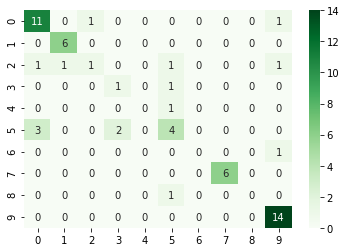

In [75]:
confo = confusion_matrix(y_test, ytestpred)   #plot confusion matrix
sns.heatmap(conf, annot=True, fmt="d", cmap="Greens")

The result is better with both models combined using Voting Classifier. However, the model is overfitting. 

### SVC Classifier

Scale the data. Train, test and split the dataset. Create the instance and train the model.

In [76]:
def tratesSpt(df1):
    fcols = [x for x in df1.columns if x not in "language"] #select all feature columns
    X, y = df1[fcols], df1["language"]      #X as feature columns, y as target columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)
    scale = StandardScaler() #Scale the data
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    svc = SVC().fit(X_train, y_train)  #Fit the model  
    y_tra_pred = svc.predict(X_train)
    y_tes_pred = svc.predict(X_test)
    
    return svc, fcols, X_train, X_test, y_train, y_test, y_tra_pred, y_tes_pred

svc, fcols, X_train, X_test, y_train, y_test, y_tra_pred, y_tes_pred = tratesSpt(df1)

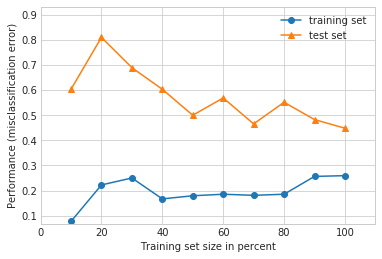

In [77]:
plot_learning_curves(X_train, y_train, X_test, y_test, svc, print_model=False, style="seaborn-whitegrid")
plt.show()

From the learning curve, we can see the error rate is high. 

In [78]:
def sco(yt, ypred, label):
   
    cscore = pd.Series({"accuracy": accuracy_score(yt, ypred),  #Evaluate with classification metrics
                        "precision": precision_score(yt, ypred,  average='weighted'),
                        "recall": recall_score(yt, ypred,  average='weighted'),
                        "f1": f1_score(yt, ypred,  average='weighted')}, name=label)
    
    return cscore
   
svcmetrics = pd.concat([sco(y_train, y_tra_pred, "train"), sco(y_test, y_tes_pred, "test")], axis=1)

svcmetrics

,train,test
accuracy,0.740741,0.551724
precision,0.781088,0.495410
recall,0.740741,0.551724
f1,0.723972,0.497205


Let's fine tune the model using gridsearch.

In [79]:
def gsSea(svc, X_train, X_test, y_train, y_tes):
    #input parameters for fine tuning
    c_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
    ker = ["linear" "poly", "rbf", "sigmoid"]  
    param_grid = {"C": c_range, "kernel": ker}   
    gs = GridSearchCV(estimator=svc, param_grid=param_grid, scoring = "accuracy", cv=4).fit(X_train, y_train)     
    print("The best parameter: {}".format(gs.best_params_))  #get best parameter of the classifier
    
gsSea(svc, X_train, X_test, y_train, y_test)

The best parameter: {'C': 1.0, 'kernel': 'rbf'}


In [80]:
def tun():
    #tune parameter of model
    svc = SVC(C= 1.0, kernel="rbf", probability=True).fit(X_train, y_train)  
    y_tra_pred = svc.predict(X_train)
    y_tes_pred = svc.predict(X_test)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
        .format(accuracy_score(y_train, y_tra_pred), accuracy_score(y_test, y_tes_pred)))

    return svc, y_tra_pred, y_tes_pred

svc, y_tra_pred, y_tes_pred = tun()

accuracy-train: 0.740741 
accuracy-test: 0.551724


There is no improvement as both training and testing set performs poorly. 
Let's proceed with boosting. 

In [81]:
def xgb():
    xgb = XGBClassifier(learning_rate=0.02, random_state=123)  
    xgb.fit(X_train, y_train)       #using xgboost
    y_tespred = xgb.predict(X_test)  
    y_trapred = xgb.predict(X_train)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
          .format(accuracy_score(y_train, y_trapred), accuracy_score(y_test, y_tespred)))
    
    return xgb, y_trapred, y_tespred

xgb, y_trapred, y_tespred = xgb()

accuracy-train: 0.977778 
accuracy-test: 0.706897


In [82]:
def vote():
    estimators = [("svc", svc), ("xgb", xgb)]   #Combine both models
    vc = VotingClassifier(estimators, voting="soft")
    vc = vc.fit(X_train, y_train)  
    y_tespred = vc.predict(X_test)
    y_trapred = vc.predict(X_train)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
          .format(accuracy_score(y_train, y_trapred), accuracy_score(y_test, y_tespred)))

    return vc, y_tespred, y_trapred

vc, y_tespred, y_trapred = vote()

accuracy-train: 0.925926 
accuracy-test: 0.672414


In [83]:
print(classification_report(y_train, y_trapred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         4
           5       0.00      0.00      0.00         3
           6       1.00      1.00      1.00        21
           7       0.00      0.00      0.00         3
           8       1.00      0.92      0.96        13
           9       0.00      0.00      0.00         3
          10       0.76      1.00      0.86        31

    accuracy                           0.93       135
   macro avg       0.68      0.69      0.68       135
weighted avg       0.88      0.93      0.90       135



In [84]:
print(classification_report(y_test, y_tespred))

              precision    recall  f1-score   support

           1       0.62      0.77      0.69        13
           2       0.86      1.00      0.92         6
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.50      0.56      0.53         9
           7       0.00      0.00      0.00         1
           8       1.00      0.83      0.91         6
           9       0.00      0.00      0.00         1
          10       0.63      0.86      0.73        14

    accuracy                           0.67        58
   macro avg       0.46      0.42      0.41        58
weighted avg       0.65      0.67      0.63        58



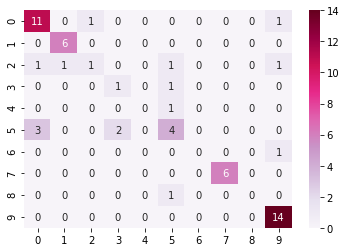

In [85]:
confo = confusion_matrix(y_test, y_tespred)
sns.heatmap(conf, annot=True, fmt="d", cmap="PuRd")

Text(0.5, 0, 'Ground Truth')

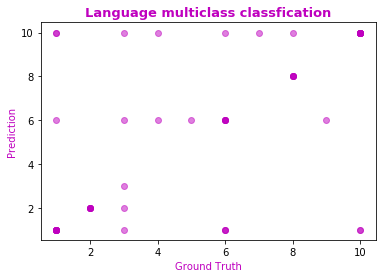

In [86]:
plt.scatter(y_test, y_tespred, alpha=.5, color="m")
plt.title("Language multiclass classfication", fontsize=13, color="m", fontweight="bold")
plt.ylabel("Prediction", color="m")
plt.xlabel("Ground Truth", color="m")

This model is not performing any better than the Logistic Regression and Decision Tree classifiers. Lastly, we will proceed with all the stacked classifier by stacking the above estimators with a final classifier.

### Stacked Classifier

Stacking allows the strength of individual estimator and use their output as input of a final estimator. We will see if the performance improves.

In [100]:
def stack():
    #Since the results of all the three models are overfitting, we will use a regularized model, ridgeclassifier as the final estimator 
    ridge = RidgeClassifier(alpha=1) #Initiate ridge classifier, it is a penalized linear regression model but can also be used for classification
    estimators = [("DTC", bc),("LR", VC), ("SVC", vc)]
    sc = StackingClassifier(estimators=estimators, final_estimator=ridge).fit(X_train, y_train)
    ytrpred = sc.predict(X_train)
    ytepred = sc.predict(X_test)
    print("accuracy-train: {:.6f} \naccuracy-test: {:.6f}"
          .format(accuracy_score(y_train, ytrpred), accuracy_score(y_test, ytepred)))
    print("precision-train: {:.6f} \nprecision-test: {:.6f}"
          .format(precision_score(y_train, ytrpred, average="weighted"), precision_score(y_test, ytepred, average="weighted")))
    print("recall-train: {:.6f} \nrecall-test: {:.6f}"
          .format(recall_score(y_train, ytrpred, average="weighted"), recall_score(y_test, ytepred, average="weighted")))
    print("f1-train: {:.6f} \nf1-test: {:.6f}"
          .format(f1_score(y_train, ytrpred, average="weighted"), f1_score(y_test, ytepred, average="weighted")))
    
    return sc

sc = stack()

accuracy-train: 0.829630 
accuracy-test: 0.741379
precision-train: 0.757670 
precision-test: 0.615972
recall-train: 0.829630 
recall-test: 0.741379
f1-train: 0.788192 
f1-test: 0.671364


Now we are going to do cross-validation and compare the result across all the models.

In [102]:
def compare():
    clf_cv_mean = [] 
    clf_cv_std = []
    X, y = df1[fcols], df1["language"]
    label = ["Bagging", "VC: LR and GBC", "VC: SVC and XGB", "Stacking Classifier"]   
    list = [bc, VC, vc, sc]  #list of classifier to compute cv score
    
    print("Cross Validation:\n")
    for clf, label in zip(list, label):         
        
        scs = cross_val_score(clf, X, y, cv=StratifiedKFold(5, shuffle=True), scoring="accuracy")
        print("{} {}".format(label, scs))
        print("Mean Accuracy: {:.2f} (+/- {:.2f})\n".format(scs.mean(), scs.std()))
        clf_cv_mean.append(scs.mean())   #append mean cv score to list
        clf_cv_std.append(scs.std())     #append cv s.d score to list
   
compare()

Cross Validation:

Bagging [0.53846154 0.61538462 0.58974359 0.55263158 0.60526316]
Mean Accuracy: 0.58 (+/- 0.03)

VC: LR and GBC [0.58974359 0.58974359 0.58974359 0.60526316 0.52631579]
Mean Accuracy: 0.58 (+/- 0.03)

VC: SVC and XGB [0.51282051 0.58974359 0.58974359 0.65789474 0.57894737]
Mean Accuracy: 0.59 (+/- 0.05)

Stacking Classifier [0.64102564 0.61538462 0.74358974 0.63157895 0.55263158]
Mean Accuracy: 0.64 (+/- 0.06)



The last model performs slightly better than the rest of the models.